# Assignment 2

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdata2025/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: 
 - The assignment is due on Monday March 31st, 2025 at 23:55. 
 - Hand via DTU Learn. 
 - You should simply hand in the link to the github page with your short data story.

## A2: A short data story

This assignment is to create a short data-story based on the work we've done in class so far. See **Exercises Week 8, Part 2** for full details on how the story should be constructed.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from bokeh.plotting import figure, show

# Use the given merged data.
data = pd.read_csv(r"C:\Users\Frederik\Programming\Socialdata2025\files\merged_data.csv")

In [25]:
data.Category.unique()

array(['ROBBERY', 'VEHICLE THEFT', 'ASSAULT', 'BURGLARY', 'LARCENY/THEFT',
       'DRUG/NARCOTIC', 'VANDALISM', 'WEAPON LAWS', 'PROSTITUTION',
       'STOLEN PROPERTY'], dtype=object)

In [27]:
data['Category'].shape

(1702398,)

In [ ]:
crime_data = data[data['Category'] == 'DRUG/NARCOTIC'].copy()
crime_data.head()

,Category,PdDistrict,Longitude,Latitude,TimeOfDay,DayOfWeek,DayOfMonth,Month,Year
12,DRUG/NARCOTIC,INGLESIDE,-122.441875,37.719082,20,Thursday,12,June,2003
20,DRUG/NARCOTIC,TENDERLOIN,-122.414433,37.784658,1,Tuesday,3,January,2006
25,DRUG/NARCOTIC,TENDERLOIN,-122.412883,37.785353,0,Thursday,18,December,2003
46,DRUG/NARCOTIC,SOUTHERN,-122.413564,37.779514,9,Wednesday,21,May,2003
91,DRUG/NARCOTIC,RICHMOND,-122.442365,37.784875,11,Friday,27,January,2006


# The bokeh plot for the time-series plot

In [ ]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Select, CustomJS, Toggle
from bokeh.layouts import column
from bokeh.palettes import Category20
import numpy as np  # ensure numpy is imported if needed for other parts of your code

# Creating time series using districts and year: 
district_time = crime_data.groupby(['PdDistrict', 'Year']).size().reset_index(name='Count')
district_time['alpha'] = 0.6  

districts = sorted(district_time['PdDistrict'].unique().tolist())
colors = Category20[len(districts)] if len(districts) <= 20 else Category20[20]

#  average trend across all districts per year
avg_trend = district_time.groupby('Year', as_index=False)['Count'].mean()
avg_trend['PdDistrict'] = 'Average'  # Label for hover tool
avg_source = ColumnDataSource(avg_trend)

# MULTI-LINE FORMAT
data_dict = {district: district_time[district_time['PdDistrict'] == district] for district in districts}
sources = {district: ColumnDataSource(data) for district, data in data_dict.items()}

# Figure 
p = figure(width=800, height=500,
           title="Trend of Drug Crimes by District Over Years",
           x_axis_label='Year', y_axis_label='Number of Incidents',
           tools="pan,wheel_zoom,box_zoom,reset")

lines = {}
for idx, district in enumerate(districts):
    lines[district] = p.line('Year', 'Count', source=sources[district],
                             line_width=2, color=colors[idx], alpha=0.6,
                             legend_label=district)

# Avg trend line 
avg_line = p.line('Year', 'Count', source=avg_source, 
                  line_width=3, color='black', alpha=0.8, 
                  line_dash='dashed', legend_label="Average Trend")

# Two column legend
p.legend.location = "top_right"  # Place legend at top-right inside the figure
p.legend.orientation = "horizontal"  # Arrange items in a horizontal layout
p.legend.label_text_font_size = "8pt"  # Reduce text size to save space
p.legend.spacing = 3  # Adjust spacing for compact display
p.legend.ncols = 2  # Split legend into two columns

# Hover over data info
hover = HoverTool(tooltips=[
    ('District', '@PdDistrict'),
    ('Year', '@Year'),
    ('Incidents', '@Count')
])
p.add_tools(hover)

# District selector
district_select = Select(
    title='Select District to Highlight:',
    value='ALL',
    options=['ALL'] + districts
)

# JAVASCRIPT CALLBACK FOR DISTRICT SELECTION
callback = CustomJS(args=dict(lines=lines), code="""
    const selected = cb_obj.value;
    for (const [key, line] of Object.entries(lines)) {
        line.glyph.line_alpha = (selected === 'ALL' || key === selected) ? 1.0 : 0.2;
    }
""")
district_select.js_on_change('value', callback)

# TOGGLE BUTTON TO SHOW/HIDE AVERAGE TREND
toggle_avg = Toggle(label="Show Average Trend", active=True)
toggle_callback = CustomJS(args=dict(line=avg_line), code="""
    line.glyph.line_alpha = this.active ? 0.8 : 0;
""")
toggle_avg.js_on_change("active", toggle_callback)
layout = column(district_select, toggle_avg, p)
output_file("drug_crimes_trend.html")
show(layout)


# Follium interactive heatmap of the drug crimes from covid lockdown to lifted lockdown

In [ ]:
import folium
from folium.plugins import HeatMap

# Convert Month names to month numbers
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}


crime_data_processed = crime_data.copy()
# Convert Month names to numeric values using the mapping
crime_data_processed['MonthNum'] = crime_data_processed['Month'].map(month_mapping)
filtered_data = crime_data_processed[
    # Start date: March 17, 2020
    ((crime_data_processed['Year'] == 2020) & (crime_data_processed['MonthNum'] == 3) & (crime_data_processed['DayOfMonth'] >= 17)) |
    ((crime_data_processed['Year'] == 2020) & (crime_data_processed['MonthNum'] > 3)) |
    # End date: June 15, 2021
    ((crime_data_processed['Year'] == 2021) & (crime_data_processed['MonthNum'] < 6)) |
    ((crime_data_processed['Year'] == 2021) & (crime_data_processed['MonthNum'] == 6) & (crime_data_processed['DayOfMonth'] <= 15))
]

# data counts
print(f"Original data count: {len(crime_data)}")
print(f"Data between March 17, 2020 and June 15, 2021: {len(filtered_data)}")

# Filter for drug-related crimes
drug_crimes = filtered_data[filtered_data['Category'].str.contains('DRUG', case=False, na=False)]
print(f"Drug crimes in period: {len(drug_crimes)}")

# Filter invalid coordinates
valid_data = drug_crimes.dropna(subset=['Latitude', 'Longitude'])
valid_data = valid_data[(valid_data['Latitude'] > 37.7) & 
                         (valid_data['Latitude'] < 37.85) & 
                         (valid_data['Longitude'] > -122.5) & 
                         (valid_data['Longitude'] < -122.35)].copy()

print(f"Drug crimes with valid coordinates: {len(valid_data)}")

# If no data was found in the date range, expand to include all data for demonstration
# In the event that no data is found. 
if len(valid_data) == 0:
    print("No data found in specified date range. Checking for any DRUG crimes in dataset...")
    
    # Filter for drug-related crimes in entire dataset
    all_drug_crimes = crime_data_processed[crime_data_processed['Category'].str.contains('DRUG', case=False, na=False)]
    valid_data = all_drug_crimes.dropna(subset=['Latitude', 'Longitude'])
    valid_data = valid_data[(valid_data['Latitude'] > 37.7) & 
                            (valid_data['Latitude'] < 37.85) & 
                            (valid_data['Longitude'] > -122.5) & 
                            (valid_data['Longitude'] < -122.35)].copy()
    
    print(f"Found {len(valid_data)} drug crimes in entire dataset")
    title_note = "Note: No data found for Mar 17, 2020 - Jun 15, 2021. Showing all available data."
else:
    title_note = "March 17, 2020 - June 15, 2021"

# Initialize the map centered on San Francisco
sf_map = folium.Map(location=[37.7749, -122.4194], 
                   zoom_start=13,
                   tiles='CartoDB positron')

# Check if we have any data to display
if len(valid_data) > 0:
    # Create and add the heatmap layer
    heat_data = valid_data[['Latitude', 'Longitude']].values.tolist()
    HeatMap(
        heat_data,
        radius=15,
        gradient={
            '0.2': '#2874A6',  # Blue for lower density
            '0.4': '#5DADE2', 
            '0.6': '#F1C40F',  # Yellow for medium density
            '0.8': '#E67E22',
            '1.0': '#CB4335'   # Red for higher density 
        },
        min_opacity=0.5,
        blur=15,
        max_zoom=13,
    ).add_to(sf_map)

# Add a title to the map
title_html = f'''
<h3 align="center" style="font-size:16px"><b>Heatmap over Drug/Narcotic Crimes in San Francisco during Covid Lockdown </b></h3>
<h4 align="center" style="font-size:12px"><i>{title_note}</i></h4>
<h4 align="center" style="font-size:12px"><i>Source: San Francisco Police Department Crime Data</i></h4>
'''
sf_map.get_root().html.add_child(folium.Element(title_html))

if len(valid_data) > 0:
    # Districits
    district_counts = valid_data['PdDistrict'].value_counts().to_dict()
    district_colors = {
        'CENTRAL': 'red',
        'SOUTHERN': 'blue',
        'BAYVIEW': 'green',
        'MISSION': 'purple',
        'NORTHERN': 'orange',
        'PARK': 'darkgreen',
        'RICHMOND': 'darkblue',
        'INGLESIDE': 'cadetblue',
        'TARAVAL': 'darkpurple',
        'TENDERLOIN': 'darkred'
    }

    # markers for key districts
    for district, count in sorted(district_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        # Find the centroid of crimes in this district
        district_data = valid_data[valid_data['PdDistrict'] == district]
        lat = district_data['Latitude'].mean()
        lon = district_data['Longitude'].mean()
        
        # Default coordinates if mean calculation fails
        if np.isnan(lat) or np.isnan(lon):
            lat, lon = 37.7749, -122.4194
        
        color = district_colors.get(district, 'blue')
        folium.Marker(
            [lat, lon],
            popup=f"<b>{district} District</b><br>Cases: {count}",
            tooltip=district,
            icon=folium.Icon(color=color, icon='info-sign')
        ).add_to(sf_map)
    
    # Summary
    count_html = f'''
    <div style="position: absolute; 
                bottom: 10px; right: 10px; width: 250px;
                border:2px solid grey; z-index:9999; font-size:12px;
                background-color: white; padding: 10px;
                border-radius: 6px;">
        <h4 style="margin-top:0;">District Summary</h4>
        <ul style="padding-left: 20px; margin-bottom: 5px;">
    '''

    # Add top 3 districts (using all would take up too much space)
    for district, count in sorted(district_counts.items(), key=lambda x: x[1], reverse=True)[:3]:
        percentage = (count / len(valid_data)) * 100
        count_html += f"<li><b>{district}:</b> {count} cases ({percentage:.1f}%)</li>"

    count_html += f'''
        </ul>
        <p><b>Total Drug Crimes:</b> {len(valid_data)}</p>
    </div>
    '''
    sf_map.get_root().html.add_child(folium.Element(count_html))

    # Add day of week 
    day_counts = valid_data['DayOfWeek'].value_counts()
    day_html = f'''
    <div style="position: absolute; 
                bottom: 10px; left: 10px; width: 250px;
                border:2px solid grey; z-index:9999; font-size:12px;
                background-color: white; padding: 10px;
                border-radius: 6px;">
        <h4 style="margin-top:0;">Day of Week Analysis</h4>
        <ul style="padding-left: 20px; margin-bottom: 5px;">
    '''

    # Add top 3 days (don't want to take up too much space)
    for day, count in day_counts.head(3).items():
        percentage = (count / len(valid_data)) * 100
        day_html += f"<li><b>{day}:</b> {count} cases ({percentage:.1f}%)</li>"

    day_html += '''
        </ul>
    </div>
    '''
    sf_map.get_root().html.add_child(folium.Element(day_html))

folium.LayerControl().add_to(sf_map)
sf_map.save('drug_crime_heatmap.html') # Easier to load

Original data count: 140908
Data between March 17, 2020 and June 15, 2021: 2660
Drug crimes in period: 2660
Drug crimes with valid coordinates: 2644


# Bar plot from start of covid to now

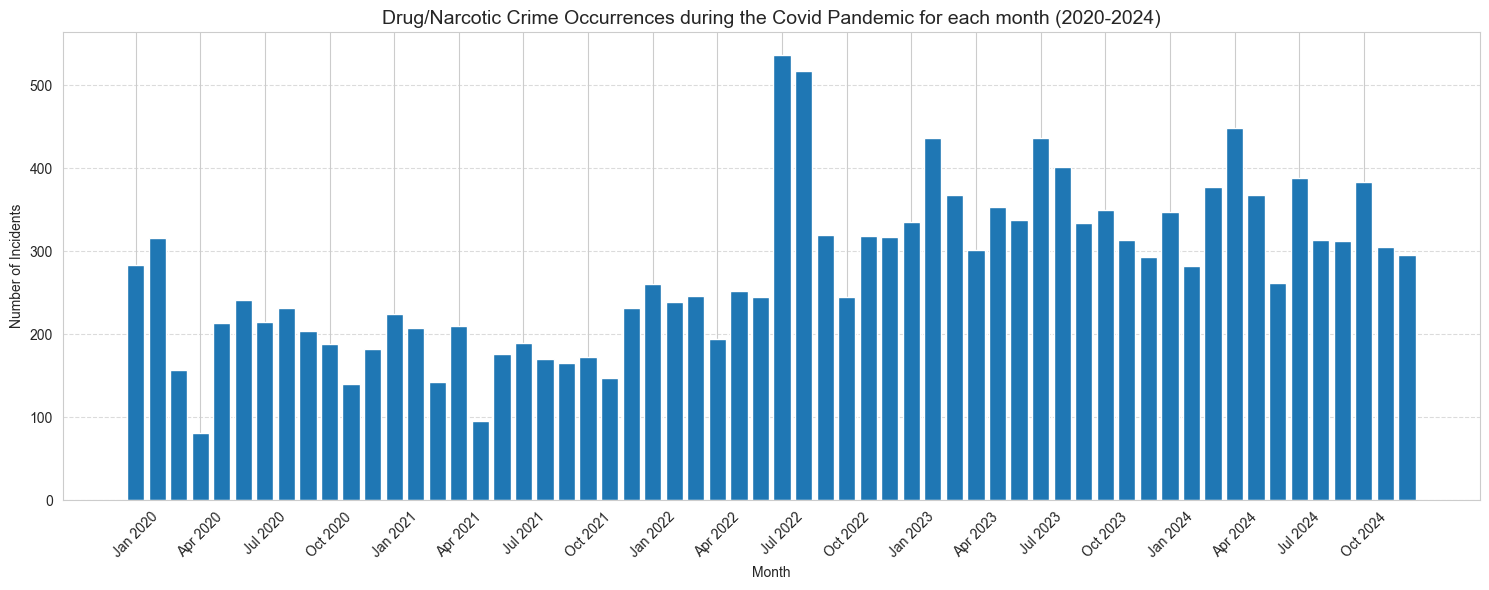

In [ ]:
filtered_data = crime_data[(crime_data['Year'] >= 2020) & (crime_data['Year'] <= 2024)]
crime_counts = filtered_data.groupby(['Year', 'Month']).size().reset_index(name='Count')

# convert month names to numbers
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
crime_counts['month_num'] = crime_counts['Month'].map(month_mapping)
crime_counts['date_label'] = crime_counts['Month'].str[:3] + ' ' + crime_counts['Year'].astype(str)

# Sort by year and month
crime_counts = crime_counts.sort_values(['Year', 'month_num'])

plt.figure(figsize=(15, 6))
plt.bar(range(len(crime_counts)), crime_counts['Count'])
plt.xticks(
    range(0, len(crime_counts), 3), 
    crime_counts['date_label'].iloc[::3],
    rotation=45
)
plt.title('Drug/Narcotic Crime Occurrences during the Covid Pandemic for each month (2020-2024)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('occurances_pandemic.png', bbox_inches='tight')
plt.show()